In [14]:
# Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stemmer = EnglishStemmer(ignore_stopwords=True)
tokenize = TfidfVectorizer().build_tokenizer()


def stemmed_words(doc):
    return (stemmer.stem(w) for w in tokenize(doc))

# reading the data
dt_true = pd.read_csv('clickbait_data.txt', sep='\n', names=['Title'])
dt_false = pd.read_csv('non_clickbait_data.txt', sep='\n', names=['Title'])
dt_true = dt_true.assign(Label=lambda x: True)
dt_false = dt_false.assign(Label=lambda x: False)

# merging the data
dt = pd.concat([dt_true, dt_false], ignore_index=True)

# shulffing data
dt = shuffle(dt).reset_index(drop=True)

# computing tf-idf
data = dt['Title'].to_list()
nr_pattern = re.compile(r'\b[+-]?\d*[.,]?\d+([eE][+-]?\d+)?\b')
acronyms = re.compile(r'\b(\w)[.+:\-]')
non_alphanum = re.compile(r'[^\w\d\-\+\s]')
for i in range(len(data)):
    title = acronyms.sub(r'\1', data[i])
    title = non_alphanum.sub(' ', title)
    data[i] = nr_pattern.sub('NUMBER_SPECIAL_TOKEN', title)
vectorizer = TfidfVectorizer(
    tokenizer=stemmed_words, stop_words=stopwords.words('english'), max_features=1000)
X = vectorizer.fit_transform(data).toarray()
Xlabel = vectorizer.get_feature_names()
y = dt['Label']  # labels

print(X.shape)
print(len(Xlabel))
print(y.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
(32000, 1000)
1000
(32000,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size=.3, random_state=1)

### Train and Print a Decision Tree

In [17]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
# interval confidence
from statsmodels.stats.proportion import proportion_confint

#run without any specified param
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Obtain accuracy score of learned classifier on test data
print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, pred))
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(sklearn.metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test')




0.8702083333333334
[[4108  742]
 [ 504 4246]]

Accuracy: 0.8702083333333334

              precision    recall  f1-score   support

       False       0.89      0.85      0.87      4850
        True       0.85      0.89      0.87      4750

    accuracy                           0.87      9600
   macro avg       0.87      0.87      0.87      9600
weighted avg       0.87      0.87      0.87      9600



(0.8633440075860118, 0.8768345550812582)

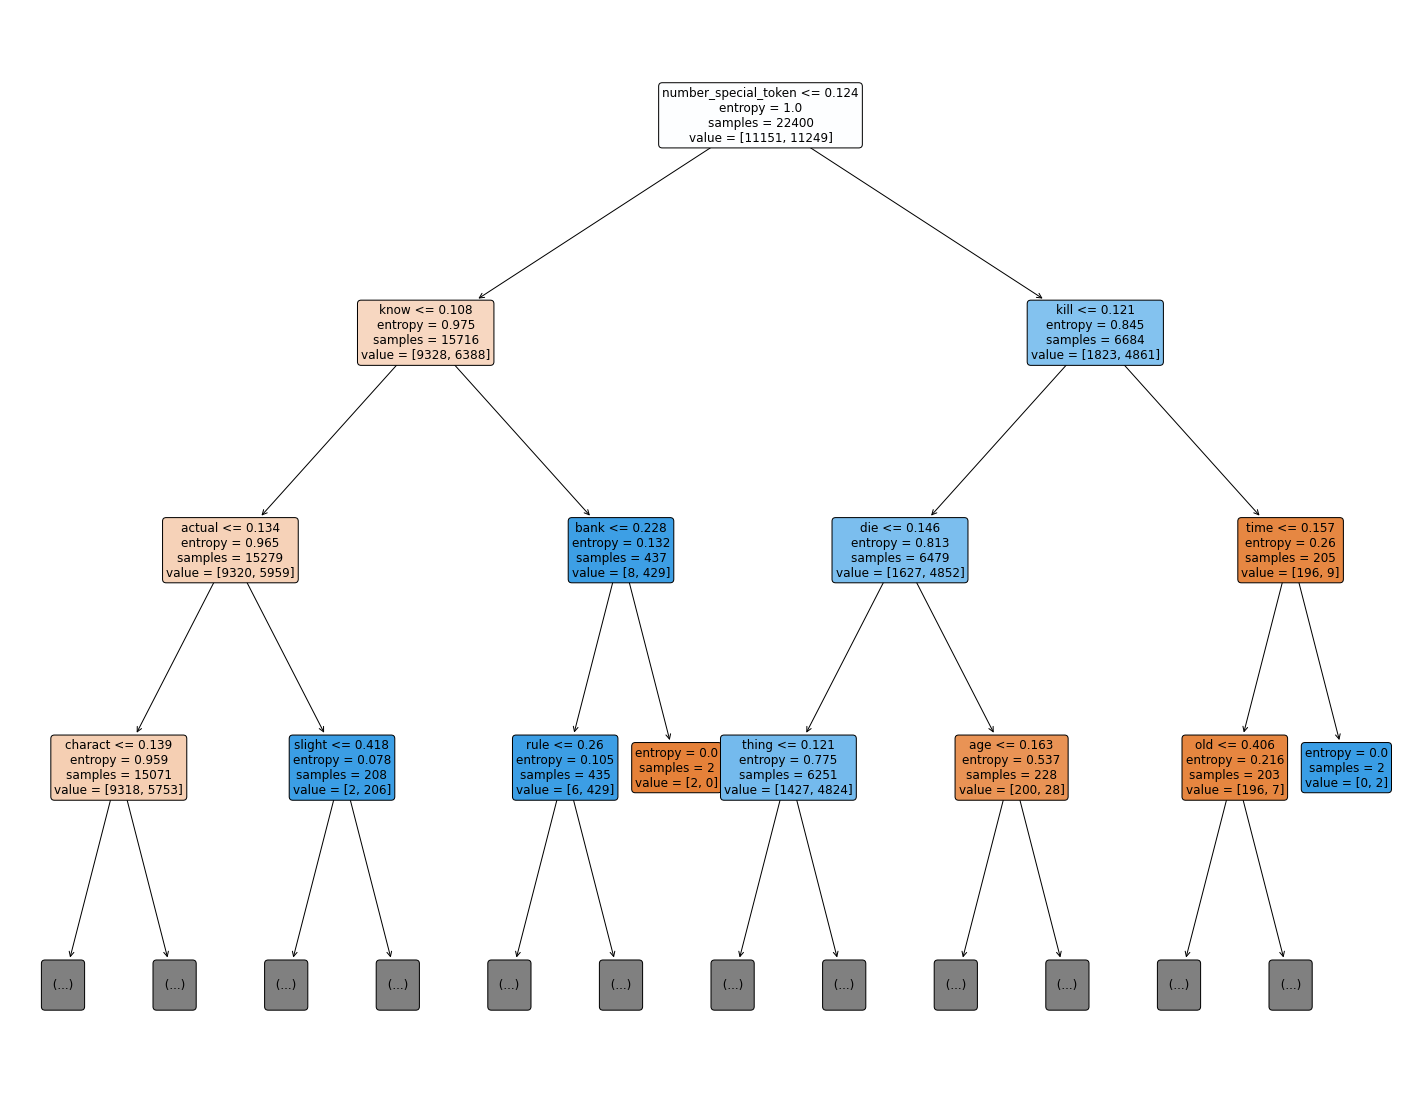

In [22]:
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(clf, filled=True,rounded=True, max_depth = 3, feature_names=Xlabel, fontsize=12)
fig.savefig('tree1.png')
plt.show()


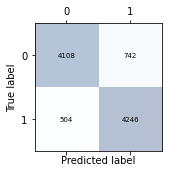

In [19]:
#plot the confusion matrix
confmat=confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix1.png', dpi=600)
plt.show()

In [20]:
#do a k-fold to compare
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=10)
print(scores)
print(np.mean(scores))

[0.8675    0.8840625 0.88125   0.869375  0.8759375 0.8696875 0.8821875
 0.8803125 0.8759375 0.8575   ]
0.874375


### Train a decision tree with parameters from grid search

In [23]:
#use gridsearch to find best parameters
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': list(np.linspace(0,0.5,21)),'min_samples_split':list(range(2,20,11))}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'min_impurity_decrease': 0.0, 'min_samples_split': 13} Accuracy= 0.8659821428571428


Best parameters tend to differ, what we've got so far:

Best Params= {'min_impurity_decrease': 0.0, 'min_samples_split': 13} Accuracy= 0.869330357142857

Best Params= {'min_impurity_decrease': 0.0, 'min_samples_split': 2} Accuracy= 0.8711160714285715

Best Params= {'min_impurity_decrease': 0.0, 'min_samples_split': 2} Accuracy= 0.8679910714285715


In [24]:
#run decision tree with these best parameters
clf=tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=clf.best_params_['min_samples_split'],min_impurity_decrease=clf.best_params_['min_impurity_decrease'])
#clf=tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2,min_impurity_decrease=0.0)

clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Obtain accuracy score of learned classifier on test data
print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, pred))
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(sklearn.metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
print("Interval of confidence:", proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test'))



0.87
[[4126  724]
 [ 524 4226]]

Accuracy: 0.87

              precision    recall  f1-score   support

       False       0.89      0.85      0.87      4850
        True       0.85      0.89      0.87      4750

    accuracy                           0.87      9600
   macro avg       0.87      0.87      0.87      9600
weighted avg       0.87      0.87      0.87      9600

Interval of confidence: (0.863084242293203, 0.8766261414308438)


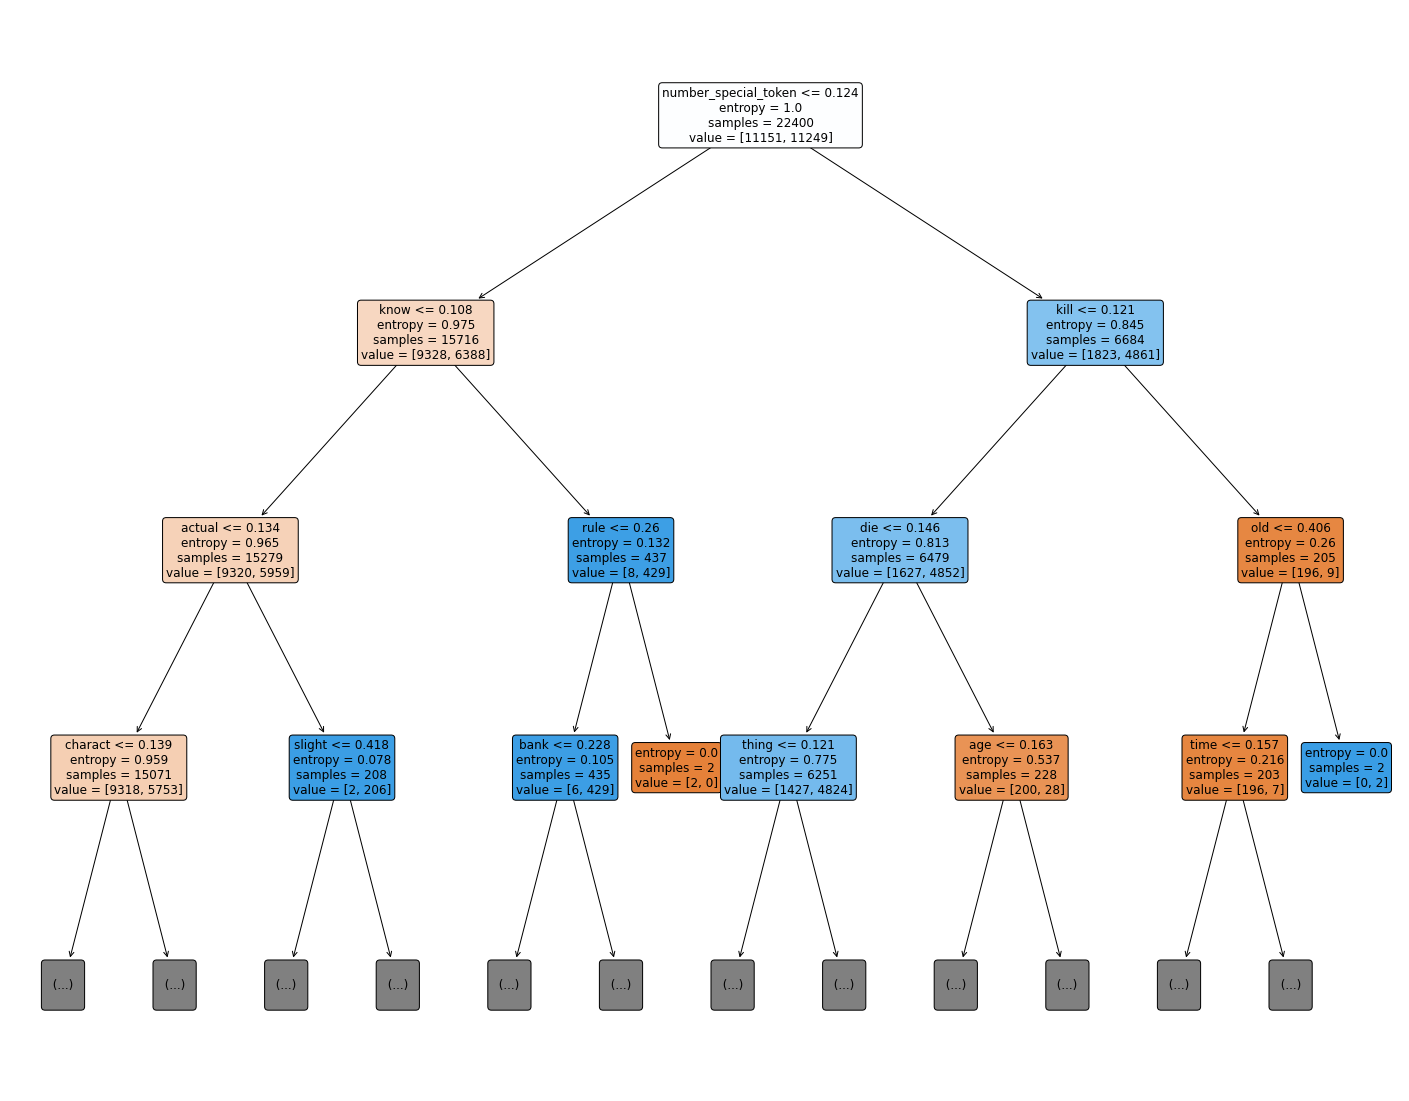

In [37]:
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(clf, filled=True,rounded=True, max_depth = 3, feature_names=Xlabel, fontsize=12)
fig.savefig('tree2.png')
plt.show()

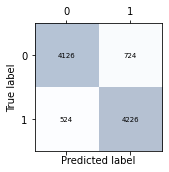

In [26]:
#plot confusion matrix for second decision tree
confmat=confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix2.png', dpi=600)
plt.show()


In [27]:
#do a k-fold to compare
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=10)
print(scores)
print(np.mean(scores))

[0.87      0.8834375 0.8896875 0.870625  0.87625   0.871875  0.8865625
 0.8803125 0.8725    0.865625 ]
0.8766875000000001


In [40]:
treeObj = clf.tree_
print (treeObj.node_count)

4125
